## First, import the libraries we will use

In [187]:
%matplotlib inline

import numpy as np
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

## Open the GOES-17 NetCDF File
Using xarray, I assign the opened file to the variable C for the CONUS domain.

In [188]:
#GOES 16 all in one file
#FILE = 'OR_ABI-L2-MCMIPC-M3_G16_s20190422102136_e20190422104509_c20190422105021.nc'

#GOES 17 on Amazon, each channel in a different file
FILE_5 ='OR_ABI-L2-CMIPC-M3C05_G17_s20190422102163_e20190422104536_c20190422105008.nc'
FILE_3 = 'OR_ABI-L2-CMIPC-M3C03_G17_s20190422102163_e20190422104536_c20190422104597.nc'

#C = xarray.open_dataset(FILE)
C_5 = xarray.open_dataset(FILE_5)
C_3 = xarray.open_dataset(FILE_3)

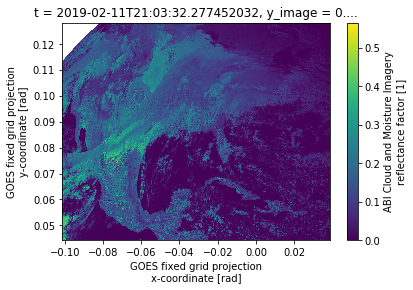

In [189]:
C.CMI_C05.plot()

## Date and Time Information
Each file represents the data collected during one scan sequence for the domain. There are several different time stamps in this file, which are also found in the file's name.

In [190]:
# Scan's start time, converted to datetime object
scan_start = datetime.strptime(C_5.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# Scan's end time, converted to datetime object
scan_end = datetime.strptime(C_5.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# File creation time, convert to datetime object
file_created = datetime.strptime(C_5.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

# The 't' variable is the scan's midpoint time
# I'm not a fan of numpy datetime, so I convert it to a regular datetime object
midpoint = str(C_5['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

print('Scan Start    : %s' % scan_start)
print('Scan midpoint : %s' % scan_mid)
print('Scan End      : %s' % scan_end)
print('File Created  : %s' % file_created)
print('Scan Duration : %.2f minutes' % ((scan_end-scan_start).seconds/60))

Scan Start    : 2019-02-11 21:02:16.300000
Scan midpoint : 2019-02-11 21:03:35
Scan End      : 2019-02-11 21:04:53.600000
File Created  : 2019-02-11 21:05:00.800000
Scan Duration : 2.62 minutes


In [191]:
# Confirm that each band is the wavelength we are interested in
#for band in [ 3, 5]:
#    print("%s is %.2f %s" % (C['band_wavelength_C%02d' % band].long_name,
#                             C['band_wavelength_C%02d' % band][0],
#                             C['band_wavelength_C%02d' % band].units))

In [192]:
# Load the two channels into appropriate G and NIR variables
#NIR = C['CMI_C05'].data
#G = C['CMI_C03'].data

NIR = C_5['CMI'].data
G = C_3['CMI'].data


In [193]:
# values must be between 0 and 1.
NIR = np.clip(NIR, 0, 1)
G = np.clip(G, 0, 1)



## Simple Image
Use `plt.imshow` to get a quick look at the channels and RGB composite we created.

First, we plot each channel individually. The deeper the color means the satellite is observing more light in that channel. Clouds appear white becuase they reflect lots of red, green, and blue light. You will also notice that the land reflects a lot of "green" in the veggie channel becuase this channel is sensitive to the chlorophyll.

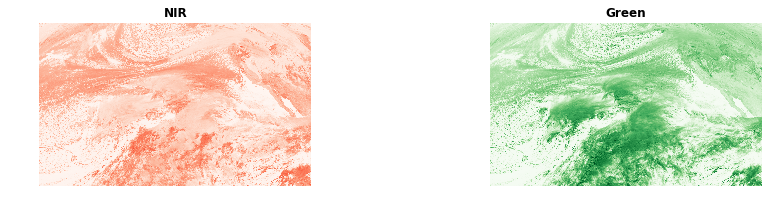

In [194]:
fig, ([ax1, ax2]) = plt.subplots(1, 2, figsize=(16,3))

ax1.imshow(NIR, cmap='Reds', vmax=1, vmin=0)
ax1.set_title('NIR', fontweight='semibold')
ax1.axis('off');

ax2.imshow(G, cmap='Greens', vmax=1, vmin=0)
ax2.set_title('Green', fontweight='semibold')
ax2.axis('off');

plt.subplots_adjust(wspace=.02)

In [195]:
C_5['goes_imager_projection']

<xarray.DataArray 'goes_imager_projection' ()>
array(-2147483647)
Coordinates:
    t        datetime64[ns] 2019-02-11T21:03:35.010718976
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    long_name:                       GOES-R ABI fixed grid projection
    grid_mapping_name:               geostationary
    perspective_point_height:        35786023.0
    semi_major_axis:                 6378137.0
    semi_minor_axis:                 6356752.31414
    inverse_flattening:              298.2572221
    latitude_of_projection_origin:   0.0
    longitude_of_projection_origin:  -137.0
    sweep_angle_axis:                x

In [196]:
# Satellite height
sat_h = C_5['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = C_5['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = C_5['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
# See details here: https://proj4.org/operations/projections/geos.html?highlight=geostationary
x = C_5['x'][:] * sat_h
y = C_5['y'][:] * sat_h

In [197]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

projection = ccrs.Geostationary(central_longitude=sat_lon, satellite_height=sat_h,
                               sweep_axis=sat_sweep)

img_extent = (x.min(), x.max(), y.min(), y.max())


#### The magic function: `pyproj.Proj`
This function creates a map projection object of the geostationary projection.

In [198]:
# Create a pyproj geostationary map object
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

In [199]:
# Perform cartographic transformation. That is, convert image projection coordinates (x and y)
# to latitude and longitude values.
XX, YY = np.meshgrid(x, y)
lons, lats = p(XX, YY, inverse=True)

# Create a pyproj geostationary map object
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)


In [200]:

# values should be between -1 and 1
NDWI = (G-NIR)/(G+NIR+.0001)
#print(NDWI)
min_ndwi = np.nanmin(NDWI)
max_ndwi = np.nanmax(NDWI)
print(min_ndwi,max_ndwi)

#for demo plotting convert to range between 0 and 1

NDWI = (NDWI+1)/2.

min_ndwi = np.nanmin(NDWI)
max_ndwi = np.nanmax(NDWI)
print(min_ndwi,max_ndwi)


-0.99450403 0.9983183
0.0027479827 0.99915916


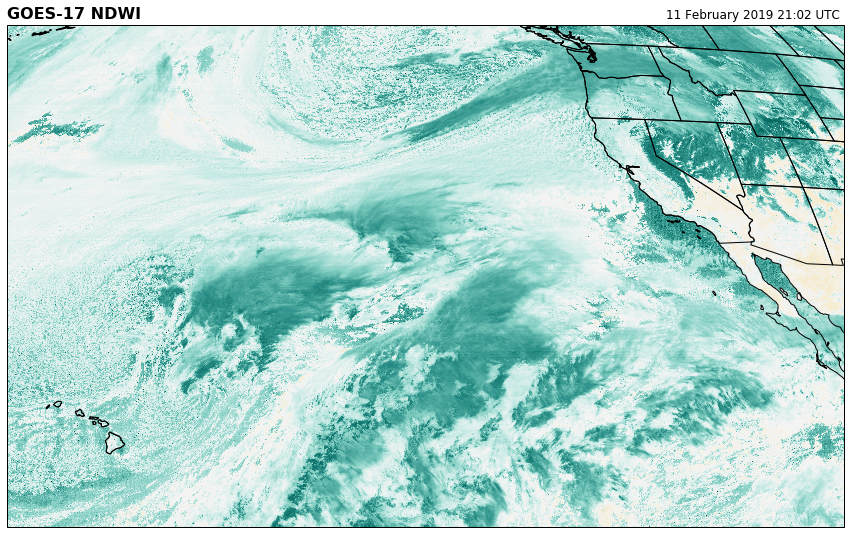

In [201]:

plt.figure(1, figsize=[15, 12])
ax = plt.axes(projection=projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))
cmap = plt.get_cmap('BrBG')
ax.imshow(NDWI, origin='upper', cmap=cmap,extent=img_extent)

plt.title('GOES-17 NDWI', loc='left', fontweight='semibold', fontsize=16)
plt.title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC '), loc='right');

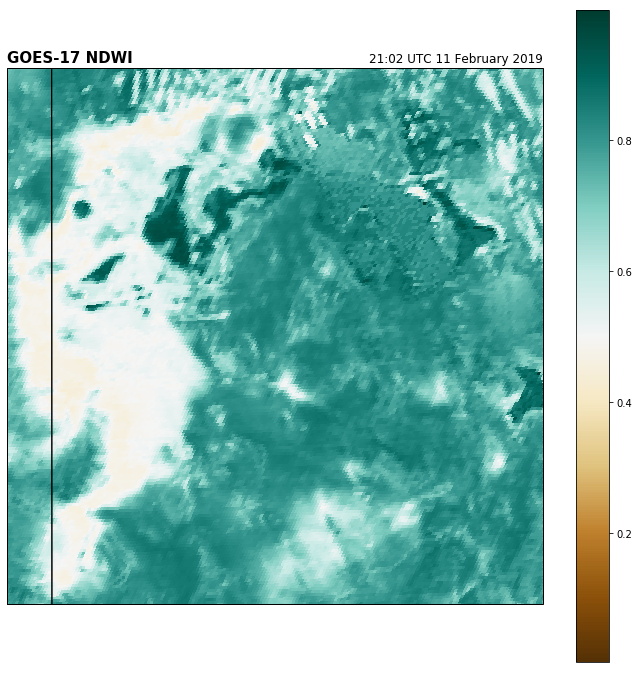

In [209]:

# Location of Utah
l = {'latitude': 40.5,
     'longitude': -113.}

projection = ccrs.PlateCarree()

# Now we can plot the GOES data on a zoomed in map centered over Utah.
plt.figure(figsize=[12,12])

cmap = plt.get_cmap('BrBG')

ax = plt.axes(projection=projection)
ax.set_extent([l['longitude']-1.25, l['longitude']+1.25, l['latitude']-1.25, l['latitude']+1.25], crs=projection)
newmap = ax.pcolormesh(lons, lats, NDWI, cmap=cmap, linewidth=0, transform=projection)


plt.colorbar(newmap, ax=ax)

ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

plt.title('GOES-17 NDWI', loc='left', fontweight='semibold', fontsize=15);
plt.title('%s' % scan_start.strftime('%H:%M UTC %d %B %Y'), loc='right');

In [203]:
l = {'latitude': 40.5,
     'longitude': -113.}

# Draw zoomed map
mZ = Basemap(resolution='i', projection='cyl', area_thresh=50000,\
             llcrnrlon=l['longitude']-1.25, llcrnrlat=l['latitude']-1.25,\
             urcrnrlon=l['longitude']+1.25, urcrnrlat=l['latitude']+1.25,)

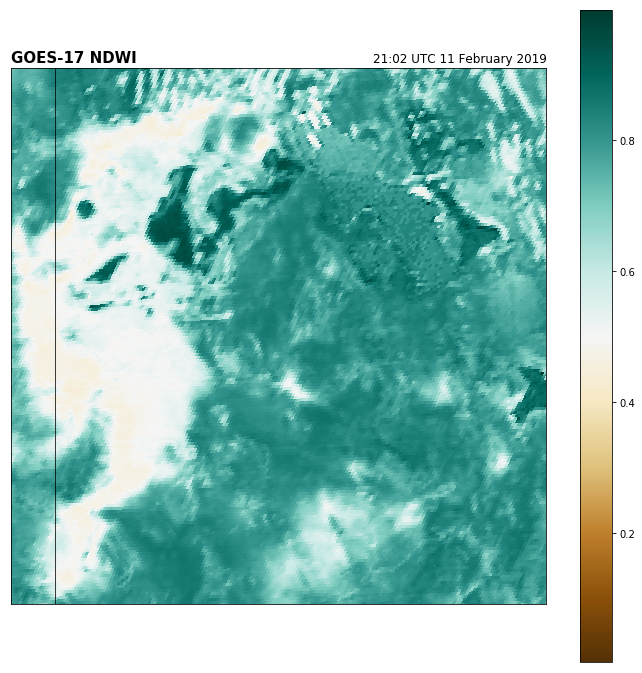

In [210]:
# Now we can plot the GOES data on a zoomed in map centered over Utah.
plt.figure(figsize=[12, 12])

cmap = plt.get_cmap('BrBG')
newmap = mZ.pcolormesh(lons, lats, NDWI, cmap=cmap, linewidth=0, latlon=True)
plt.colorbar(newmap)

mZ.drawcoastlines()
mZ.drawcountries()
mZ.drawstates()

plt.title('GOES-17 NDWI', loc='left', fontweight='semibold', fontsize=15);
plt.title('%s' % scan_start.strftime('%H:%M UTC %d %B %Y'), loc='right');

---
# Adjust Image Contrast
I think the color looks a little dull. We can make the colors pop out by adjusting the contrast. Adjusting image contrast is easy to do in Photoshop, and also easy to do in Python.

Note: you should adjust the contrast _before_ you add in the Clean IR channel.

In [205]:
def contrast_correction(color, contrast):
    """
    Modify the contrast of an RGB
    See: #www.dfstudios.co.uk/articles/programming/image-programming-algorithms/image-processing-algorithms-part-5-contrast-adjustment/

    Input:
        C - contrast level
    """
    F = (259*(contrast + 255))/(255.*259-contrast)
    COLOR = F*(color-.5)+.5
    COLOR = np.minimum(COLOR, 1)
    COLOR = np.maximum(COLOR, 0)
    return COLOR

# Amount of contrast
contrast_amount = 105

# Apply contrast correction
RGB_contrast = contrast_correction(np.dstack([R, G_true, B]), contrast_amount)

# Add in clean IR
RGB_contrast_IR = np.dstack([np.maximum(RGB_contrast[:,:,0], cleanIR), np.maximum(RGB_contrast[:,:,1], cleanIR), np.maximum(RGB_contrast[:,:,2], cleanIR)])

NameError: name 'R' is not defined

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,12))
plt.sca(ax1)
m.imshow(np.flipud(RGB_IR))
m.drawcoastlines()
m.drawcountries()
plt.title('True Color and Night IR')

plt.sca(ax2)
m.imshow(np.flipud(RGB_contrast_IR))
m.drawcoastlines()
m.drawcountries()
plt.title('Contrast=%s' % contrast_amount)

plt.subplots_adjust(wspace=.02)

----